In [5]:
import numpy as np
import networkx as nx
from torch.nn import Sequential, Linear
from _02_gnn_example2.loader import GraphDataset
from torch_geometric.loader import DataLoader
import torch_geometric.nn as nn
import torch

torch.manual_seed(123)

loaded = np.load('_02_gnn_example2/data/hard.npz', allow_pickle=True)

X_train = loaded['tr_feat'] # node features
A_train = list(loaded['tr_adj']) # list of adjacency matrices
y_train = loaded['tr_class'] # class labels

X_val = loaded['val_feat'] # node features
A_val = list(loaded['val_adj']) # list of adjacency matrices
y_val = loaded['val_class'] # class labels

X_test = loaded['te_feat'] # node features
A_test = list(loaded['te_adj']) # list of adjacency matrices
y_test = loaded['te_class'] # class labels

G_train = []
for a, x in zip(A_train, X_train):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_train.append(G)
    
G_val = []
for a, x in zip(A_val, X_val):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_val.append(G)
    
G_test = []
for a, x in zip(A_test, X_test):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_test.append(G)

train_dataset = GraphDataset(G_train, y_train)
val_dataset = GraphDataset(G_val, y_val)
test_dataset = GraphDataset(G_test, y_test)

print(train_dataset)
print(val_dataset)
print(test_dataset)

GraphDataset(1451)
GraphDataset(159)
GraphDataset(190)


In [6]:
print(train_dataset.num_node_features, train_dataset.num_classes)

print(train_dataset[0])

5 3
Data(x=[165, 5], edge_index=[2, 322], y=[1])


In [7]:
from shared.models.GNNClassifier import GNNClassifier

model = GNNClassifier(dataset=train_dataset, hidden_ch=64, message_passing_module=nn.GraphConv, seed=6)
print(model)


GNNClassifier(
  (convolutions): ModuleList(
    (0): GraphConv(5, 64)
    (1-2): 2 x GraphConv(64, 64)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
)


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [10]:
for batch in train_dataloader:
    print(batch)
    print([x.shape for x in model.get_model_inputs_from_batch(batch)])
    print(model(*model.get_model_inputs_from_batch(batch)).shape)
    break

DataBatch(x=[4545, 5], edge_index=[2, 8714], y=[32], batch=[4545], ptr=[33])
[torch.Size([4545, 5]), torch.Size([2, 8714]), torch.Size([4545])]
torch.Size([32, 64])


In [38]:
from shared.training import train_classifier


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

overall_train_acc, overall_val_acc = train_classifier(N_epochs=250,
                                                    model=model,
                                                    train_dataloader=train_dataloader,
                                                    val_dataloader=val_dataloader,
                                                    loss=loss,
                                                    optimizer=optimizer,)

Epoch    T Loss  T Acc  V Loss  V Acc

1/250    0.768   0.605   0.787   0.591
2/250    0.765   0.600   0.796   0.566
3/250    0.763   0.614   0.803   0.585
4/250    0.756   0.621   0.792   0.648
5/250    0.756   0.627   0.778   0.648
6/250    0.762   0.619   0.800   0.604
7/250    0.752   0.622   0.807   0.623
8/250    0.748   0.631   0.787   0.635
9/250    0.741   0.643   0.778   0.660
10/250   0.744   0.654   0.779   0.673
11/250   0.739   0.644   0.793   0.635
12/250   0.734   0.660   0.794   0.654
13/250   0.731   0.649   0.796   0.654
14/250   0.733   0.651   0.788   0.667
15/250   0.725   0.668   0.800   0.635
16/250   0.725   0.666   0.802   0.629
17/250   0.720   0.655   0.791   0.629
18/250   0.718   0.668   0.784   0.660
19/250   0.717   0.670   0.776   0.654
20/250   0.725   0.665   0.809   0.629
21/250   0.712   0.687   0.794   0.648
22/250   0.709   0.686   0.791   0.623
23/250   0.714   0.672   0.762   0.667
24/250   0.685   0.701   0.762   0.673
25/250   0.658   0.711   

KeyboardInterrupt: 

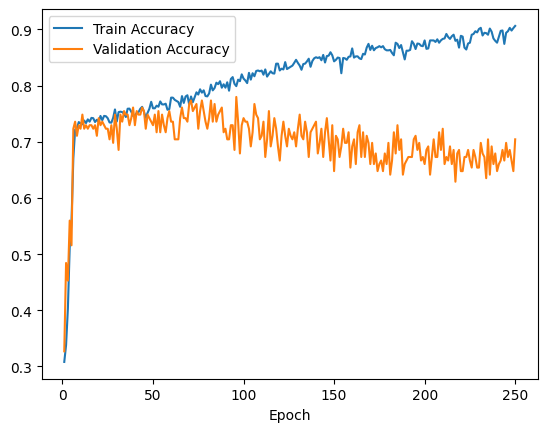

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(overall_train_acc) + 1), overall_train_acc, label='Train Accuracy')
plt.plot(range(1, len(overall_val_acc) + 1), overall_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Trying other weight init

In [ ]:
model = GNNClassifier(dataset=train_dataset, hidden_ch=64, dropout=0.7)
print(model)

GNNClassifier(
  (convolutions): ModuleList(
    (0): GCNConv(5, 64)
    (1-2): 2 x GCNConv(64, 64)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
)


In [ ]:
def init_kaiming(m):
    if isinstance(m, Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.GraphConv):
        # GraphConv has lin_l and lin_r (left and right transformation matrices)
        if hasattr(m, 'lin_l') and hasattr(m.lin_l, 'weight'):
            torch.nn.init.kaiming_normal_(m.lin_l.weight, nonlinearity='relu')
        if hasattr(m, 'lin_r') and hasattr(m.lin_r, 'weight'):
            torch.nn.init.kaiming_normal_(m.lin_r.weight, nonlinearity='relu')
        # Initialize biases to zero if they exist
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_kaiming)

GNNClassifier(
  (convolutions): ModuleList(
    (0): GCNConv(5, 64)
    (1-2): 2 x GCNConv(64, 64)
  )
  (lin_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.get_labels_from_batch = lambda batch: batch.y
model.get_features_from_batch = lambda batch: (batch.x, batch.edge_index)

overall_train_acc, overall_val_acc = train_classifier(N_epochs=250,
                                                    model=model,
                                                    train_dataloader=train_dataloader,
                                                    val_dataloader=val_dataloader,
                                                    loss=loss,
                                                    optimizer=optimizer,)

Epoch    T Loss  T Acc  V Loss  V Acc

1/250    4.530   0.273   4.159   0.352
2/250    4.159   0.332   4.159   0.352
3/250    4.159   0.333   4.159   0.352
4/250    4.159   0.331   4.159   0.352
5/250    4.159   0.337   4.159   0.352
6/250    4.159   0.337   4.159   0.352
7/250    4.159   0.333   4.159   0.352
8/250    4.159   0.333   4.159   0.352
9/250    4.159   0.335   4.159   0.352
10/250   4.159   0.333   4.159   0.352
11/250   4.159   0.333   4.159   0.352
12/250   4.159   0.333   4.159   0.352
13/250   4.159   0.333   4.159   0.352
14/250   4.159   0.333   4.159   0.352
15/250   4.159   0.335   4.159   0.352
16/250   4.159   0.332   4.159   0.352
17/250   4.159   0.337   4.159   0.352
18/250   4.159   0.336   4.159   0.352
19/250   4.159   0.332   4.159   0.352
20/250   4.159   0.335   4.159   0.352
21/250   4.159   0.337   4.159   0.352
22/250   4.159   0.336   4.159   0.352
23/250   4.159   0.337   4.159   0.352
24/250   4.159   0.333   4.159   0.352
25/250   4.159   0.333   

KeyboardInterrupt: 

A bit better (circa 2%). Can now fully overfit training data, but not much improvement on validation

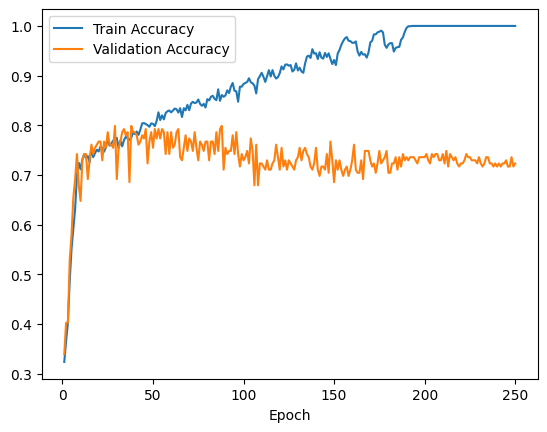

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, len(overall_train_acc) + 1), overall_train_acc, label='Train Accuracy')
plt.plot(range(1, len(overall_val_acc) + 1), overall_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()